## Data Generator

In [1]:
import sys
print(sys.version)

3.6.1 |Anaconda 4.4.0 (64-bit)| (default, May 11 2017, 13:09:58) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


In [2]:
lisa_path = "/home/dat/Downloads/training/" # Remember the `/` at the end

In [3]:
import numpy as np
from utils.parse_input import load_data    # Data handler for LISA dataset

x_train, y_train = load_data('training.txt')
labels           = np.unique(y_train[:,1])
num_classes      = len(labels)  # Count number of classes in the dataset

print("Train: {} samples\nNumber of classes: {}".format(len(x_train),num_classes))

Number of ground truth boxes: 3672 boxes
Train: 3672 samples
Number of classes: 31


In [4]:
import pandas as pd

categories = np.unique(y_train[:, 1])
label_map  = pd.factorize(categories)[0]
print(categories)
print(label_map)

['addedLane' 'bicyclesMayUseFullLane' 'curveLeft' 'curveRight' 'doNotEnter'
 'intersection' 'intersectionLaneControl' 'keepRight' 'laneEnds'
 'leftAndUTurnControl' 'merge' 'noLeftAndUTurn' 'noParking' 'noRightTurn'
 'noUTurn' 'pedestrianCrossing' 'school' 'signalAhead' 'speedBumpsAhead'
 'speedLimit15' 'speedLimit25' 'speedLimit30' 'speedLimit35' 'speedLimit40'
 'speedLimit45' 'speedLimit50' 'speedLimit60' 'stop' 'stopAhead'
 'yieldAhead' 'yieldToPedestrian']
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]


In [5]:
box = 0.5 ,0.2, 3. , 4.
one_hot = np.eye(31)[2]
label = np.concatenate([box, one_hot])
print(label)

[ 0.5  0.2  3.   4.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0. ]


In [6]:
import pandas as pd
def calc_augment_level(y, scaling_factor=5):
    """
    Calculate scale factor for each class in data set
    :param y:              List of labels data
    :param scaling_factor: how much we would like to augment each class in data set
    :return: 
    """
    categories, frequencies = np.unique(y[:,1], return_counts=True)  # Calculate how many images in one traffic sign
    mean = frequencies.mean(axis=0)  # average images per traffic sign

    df = pd.DataFrame({'label': categories, 'frequency': frequencies})
    df['scaling_factor'] = df.apply(lambda row: int(scaling_factor*(mean / row['frequency'])), axis=1)
    return df

df = calc_augment_level(y_train)
print(df[1:5])

aug_level = df.loc[df['label'] == 'curveLeft', 'scaling_factor'].values[0]
print(aug_level)

   frequency                   label  scaling_factor
1         20  bicyclesMayUseFullLane              29
2         50               curveLeft              11
3         59              curveRight              10
4         39              doNotEnter              15
11


In [44]:
"""
Data Handler for Training Deep Learning Model
"""
import os
import cv2
import pandas as pd
import numpy as np
from utils.box import Box, convert_bbox

from sklearn.utils import shuffle
from utils.image_handler import random_transform, preprocess_img
def flow_from_list(x, y, anchors, batch_size=32, scaling_factor=5, augment_data=True):
    """
    A ImageGenerator from image paths and return (images, labels) by batch_size

    Parameters
    ---------
    :param x: list of image paths 
    :param y: list of labels as [Box, label_name]

    :param anchors:        list of anchors
    :param scaling_factor: the level of augmentation. The higher, the more data being augmented
    :param batch_size:     number of images yielded every iteration
    :param augment_data:   enable data augmentation

    Return
    ------
    :return: 
        generate (images, labels) in batch_size
    """
    # @TODO: thread-safe generator (to allow nb_workers > 1)
    slices = int(len(x) / batch_size)
    if augment_data is True:
        augment_level = calc_augment_level(y, scaling_factor)  # (less data / class means more augmentation)
    categories = np.unique(y[:, 1])
    while True:
        x, y = shuffle(x, y)  # Shuffle DATA to avoid over-fitting
        for i in list(range(slices)):
            fnames = x[i * batch_size:(i * batch_size) + batch_size]
            labels = y[i * batch_size:(i * batch_size) + batch_size]
            X = []
            Y = []
            for filename, label in list(zip(fnames, labels)):
                bbox, label = label
                if not os.path.isfile(filename):
                    print('Image Not Found')
                    continue
                img = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
                height, width, _ = img.shape

                # Prep-rocess image **IMPORTANT
                processed_img = preprocess_img(img)

                # convert label to int
                index_label = np.where(categories == label)[0][0]
                one_hot = np.eye(len(categories))[index_label]
                box = bbox.to_relative_size(img_size=(width, height))
                X.append(processed_img)
                Y.append(np.concatenate([np.array(box), [index_label]]))

                if augment_data is True:
                    aug_level = augment_level.loc[augment_level['label'] == label, 'scaling_factor'].values[0]
                    for l in list(range(aug_level)):
                        # Create new image & bounding box
                        aug_img, aug_box = random_transform(img, bbox.to_opencv_format())

                        # if box is out-of-bound. skip to next image
                        p1 = (np.asarray([width, height]) - aug_box[0][0])
                        p2 = (np.asarray([width, height]) - aug_box[0][1])
                        if np.any(p1 < 0) or np.any(p2 < 0):
                            continue

                        processed_img = preprocess_img(aug_img)
                        aug_box = convert_opencv_to_box(aug_box)

                        aug_box = aug_box.to_relative_size(img_size=(width, height))
                        X.append(processed_img)
                        Y.append(np.asarray(np.concatenate([np.array(aug_box), [index_label]])))

            # Shuffle X, Y again
            X, Y = shuffle(X, Y)
            X = np.array(X)
            Y = np.array(Y)
            # X_batch = np.zeros((batch_size, NORM_W, NORM_H, 3))
            # Y_batch = np.zeros((batch_size, GRID_W, GRID_H, BOX, 5 + CLASS))

            # Generate (augmented data + original data) in correct batch_size
            iterations = list(range(int(len(X) / batch_size)))
            for z in iterations:
                yield X[z * batch_size:(z * batch_size) + batch_size], Y[z * batch_size:(z * batch_size) + batch_size]

def convert_opencv_to_box(box):
    x1, y1, x2, y2 = np.array(box).ravel()
    xc, yc, w, h = convert_bbox(x1, y1, x2, y2)
    bbox = Box(xc, yc, w, h)
    return bbox

In [45]:
anchors  = np.array(((0.57273, 0.677385),
                     (1.87446, 2.06253),
                     (3.33843, 5.47434),
                     (7.88282, 3.52778),
                     (9.77052, 9.16828)))

data_gen   = flow_from_list(x_train, y_train, anchors, batch_size=4, scaling_factor=5, augment_data=True)

In [46]:
images, labels  = data_gen.__next__()
# print("Box and class:\n{}\n\n".format(labels))

In [50]:
print(np.shape(images))
print(np.shape(labels))
print(labels)


(4, 960, 1280, 3)
(4, 5)
[[  0.70859375   0.4296875    0.034375     0.04479167  27.        ]
 [  0.69335938   0.47083333   0.03046875   0.04166667  17.        ]
 [  0.2875       0.47291667   0.0296875    0.04791667  22.        ]
 [  0.32070312   0.55052083   0.03359375   0.05520833  22.        ]]


In [54]:
GRID_W = 3
GRID_H = 4
ANCHORS = 5
s = np.shape(labels)
test = np.tile(labels, (1, GRID_W*GRID_H*ANCHORS)).reshape([s[0], GRID_W, GRID_H, ANCHORS*s[1]])
print(np.shape(test))
print(test)


(4, 3, 4, 25)
[[[[  0.70859375   0.4296875    0.034375   ...,   0.034375     0.04479167
     27.        ]
   [  0.70859375   0.4296875    0.034375   ...,   0.034375     0.04479167
     27.        ]
   [  0.70859375   0.4296875    0.034375   ...,   0.034375     0.04479167
     27.        ]
   [  0.70859375   0.4296875    0.034375   ...,   0.034375     0.04479167
     27.        ]]

  [[  0.70859375   0.4296875    0.034375   ...,   0.034375     0.04479167
     27.        ]
   [  0.70859375   0.4296875    0.034375   ...,   0.034375     0.04479167
     27.        ]
   [  0.70859375   0.4296875    0.034375   ...,   0.034375     0.04479167
     27.        ]
   [  0.70859375   0.4296875    0.034375   ...,   0.034375     0.04479167
     27.        ]]

  [[  0.70859375   0.4296875    0.034375   ...,   0.034375     0.04479167
     27.        ]
   [  0.70859375   0.4296875    0.034375   ...,   0.034375     0.04479167
     27.        ]
   [  0.70859375   0.4296875    0.034375   ...,   0.034375    

Image size: (960, 1280, 3)
[[(1111, 377), (1159, 422)]]
[[(1082, 440), (1128, 488)]]
[[(763, 433), (810, 484)]]
[[(1082, 440), (1128, 488)]]


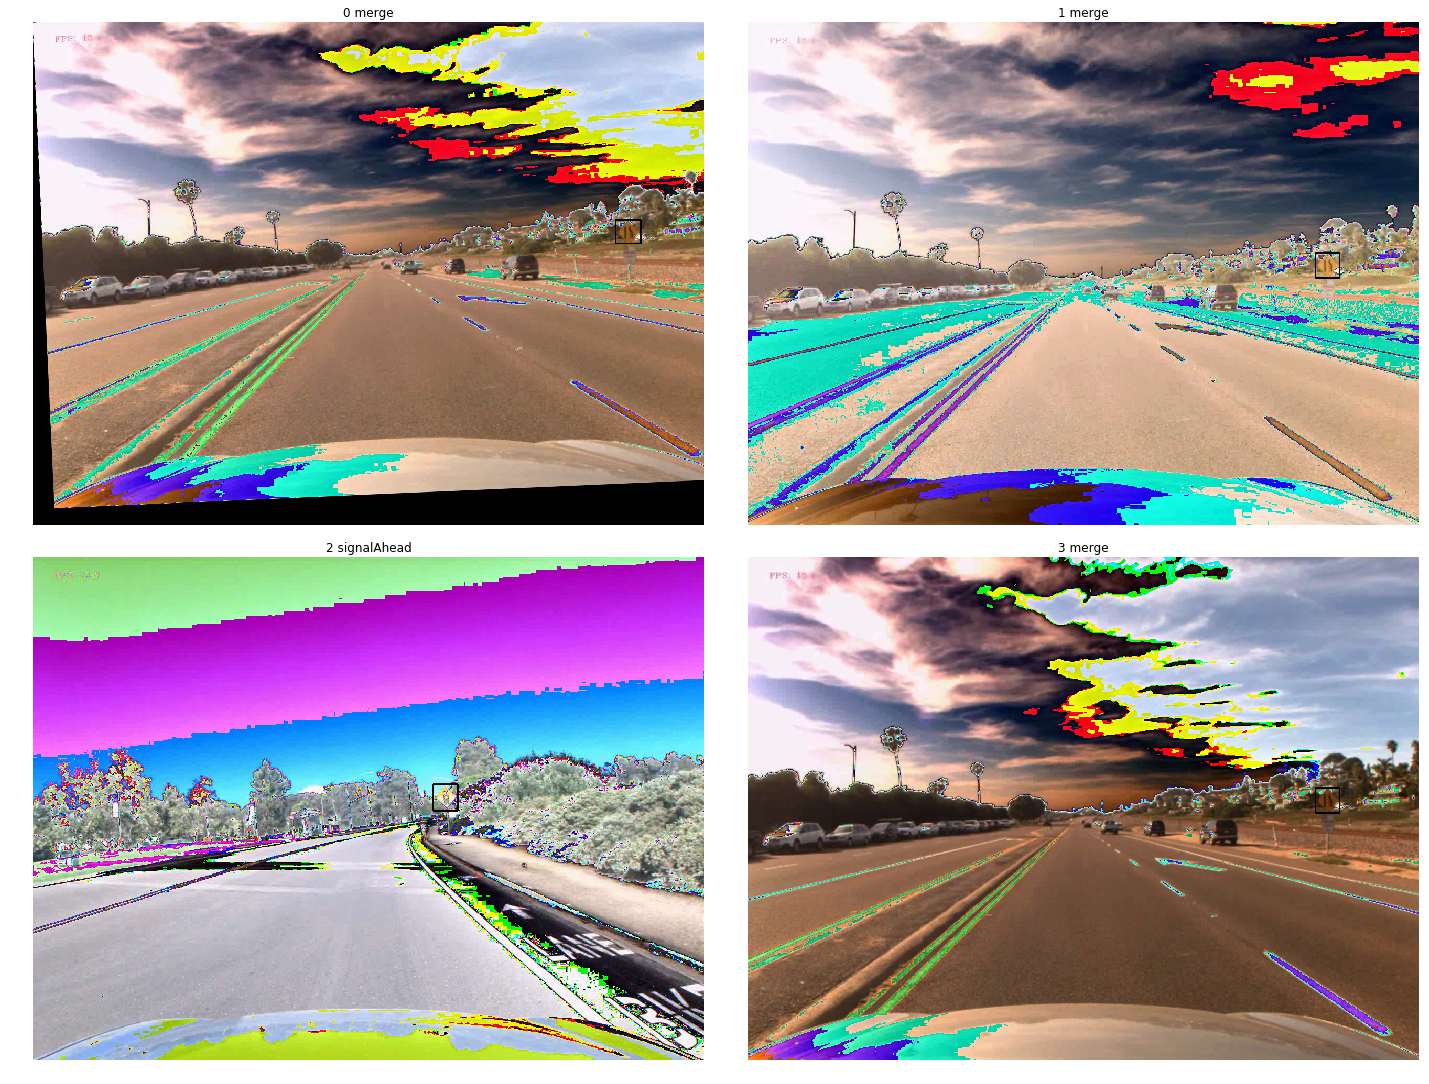

In [34]:
from utils.image_handler import draw_boxes
from utils.box import Box

import matplotlib.pyplot as plt
%matplotlib inline

label_map = np.unique(y_train[:, 1])
row, col = 2, 2
fg, a    = plt.subplots(row, col, figsize =(20, 15))
fg.tight_layout()
height, width, _ = images[0].shape
print("Image size:", images[0].shape)
i        = 0
for r in range(row):
    for c in range(col):
        xc, yc, w ,h = labels[i][0:4]
        bbox = Box(xc, yc, w ,h)
        xc, yc, w ,h = bbox.to_abs_size((width, height))
        opencv_box = Box(xc, yc, w ,h).to_opencv_format()
        print(opencv_box)
        a[r, c].axis('off')
        a[r, c].imshow(draw_boxes(images[i], opencv_box, color=(255, 255, 255), thickness=2))
        a[r, c].set_title(str(i) + " " + label_map[np.argmax(labels[i][4:])])
        i +=1

In [11]:
### Test heat map

# reshaped_mask = np.transpose(detection_masks, [0, 3, 1, 2, 4])
# test =reshaped_mask[0, 0, ...].transpose()

# print(test.shape)